In [2]:
import numpy as np
from numpy import nan
import pandas as pd
import json
from csv import writer
import os
import matplotlib.pyplot as plt
 
PATH_ROOT = os.getcwd().replace("\\","/").replace("/notebooks","")

# Util functions

In [3]:
# original vector values are both nonzero
def find_common_observations(vector1,vector2):
  vector1_bool = np.where(vector1 != 0, 1, 0)
  vector2_bool = np.where(vector2 != 0, 1, 0)
  take_indices = np.logical_and(vector1_bool,vector2_bool)
  take_indices = take_indices.nonzero()[0]
  x1 = np.take(vector1,take_indices)
  x2 = np.take(vector2,take_indices)
  return x1,x2

# Appends list of tuples to csv
def append_to_csv(file_name,column_names,cor_tuples):
  with open(file_name, 'a+', newline='') as write_obj:
    csv_writer = writer(write_obj)
    if column_names is not None:
      csv_writer.writerow(column_names)
    for cor_tuple in cor_tuples:
      csv_writer.writerow(cor_tuple)

def write_json_to(json_dict,path):
  json_to_write = json.dumps(json_dict)
  write_file = open(path,"w")
  write_file.write(json_to_write)
  write_file.close()

def read_json_from(path):
  with open(path, "r") as read_file:
    init_dict = json.load(read_file)
    if isinstance(init_dict,str):
        return eval(init_dict)
    return init_dict

# Load data

In [4]:
proteomeHD_path = f"{PATH_ROOT}/data_sources/ProteomeHD/ProteomeHD_v1_1.csv"
proteomeHD_df = pd.read_csv(proteomeHD_path)
proteomeHD_simplified_protein_ids = proteomeHD_df["Simplified_protein_ID"].to_numpy()
proteomeHD_feature_matrix = proteomeHD_df.iloc[:,4:].fillna(0).to_numpy()
proteomeHD_feature_matrix_with_na = proteomeHD_df.iloc[:,4:].to_numpy()
major_simplified_idx_lookup_path = f"{PATH_ROOT}/data_sources/ProteomeHD/major_simplified_to_idx_lookup.json"
major_simplified_idx_lookup = read_json_from(major_simplified_idx_lookup_path)

coexpression_lookup_path = f"{PATH_ROOT}/data_sources/StringDB/human/medium_confidence_coexpression_relation_lookup.json"
cooccurence_lookup_path = f"{PATH_ROOT}/data_sources/StringDB/human/medium_confidence_cooccurence_relation_lookup.json"
experiments_lookup_path = f"{PATH_ROOT}/data_sources/StringDB/human/medium_confidence_experiments_relation_lookup.json"
fusion_lookup_path = f"{PATH_ROOT}/data_sources/StringDB/human/medium_confidence_fusion_relation_lookup.json"
homology_lookup_path = f"{PATH_ROOT}/data_sources/StringDB/human/medium_confidence_homology_relation_lookup.json"
cocomplex_lookup_path = f"{PATH_ROOT}/data_sources/Corum/all_corum_complex_pairs_size_only.json"
database_lookup_path = f"{PATH_ROOT}/data_sources/StringDB/human/medium_confidence_database_relation_lookup.json"

coexpression_lookup = read_json_from(coexpression_lookup_path)
cooccurence_lookup = read_json_from(cooccurence_lookup_path)
experiments_lookup = read_json_from(experiments_lookup_path)
fusion_lookup = read_json_from(fusion_lookup_path)
homology_lookup = read_json_from(homology_lookup_path)
cocomplex_lookup = read_json_from(cocomplex_lookup_path)
database_lookup = read_json_from(database_lookup_path)

lookup_list = [coexpression_lookup,cooccurence_lookup,experiments_lookup,fusion_lookup,homology_lookup,cocomplex_lookup,database_lookup]

## Functions

In [5]:
# kNN
def get_top_k_nearest_neighbors(vector,k,candidates,dist_function):
    k += 1
    dist_to_all = np.array(list(map(lambda x: dist_function(vector,x),candidates)))
    neighbor_indices = np.argpartition(dist_to_all, k)[0:k]
    neighbor_indices = neighbor_indices[np.argsort(dist_to_all[neighbor_indices])]
    neighbor_indices = neighbor_indices[1:]
    top_k_neighbors_dist = dist_to_all[neighbor_indices]
    return neighbor_indices,top_k_neighbors_dist

# returns report json containing relations between two proteins
def eval_relation(protein1,protein2):
    report_json = {}
    for lookup in lookup_list:
        lookup_type = lookup['relation_type']
        relation_score = float('NaN')
        try:
            relation_score = lookup[protein1][protein2]
        except KeyError:
            pass
        report_json[lookup_type] = relation_score
    return report_json

# Only returns names of the top k nearest neighbors
def protein_query_simple(protein,k,dist_function,name_vector,feature_matrix,lookup):
    protein_idx = lookup[protein]
    protein_vec = feature_matrix[protein_idx]
    neighbor_indices,_ = get_top_k_nearest_neighbors(protein_vec,k,feature_matrix,dist_function)
    return name_vector[neighbor_indices] 

def get_closest_neighbors_in_embeddings(protein,k,embeddings,lookup,dist_func):
    neighbor_lists = []
    for embedding in embeddings:
        protein_vec = embedding[lookup[protein]]
        neighbor_indices,_ = get_top_k_nearest_neighbors(protein_vec,k,embedding,dist_func)
        neighbor_lists.append(neighbor_indices)
    return neighbor_lists

def get_common_closest_neighbors_in_embeddings(protein,k,embeddings,lookup,dist_func):
    neighbor_lists = get_closest_neighbors_in_embeddings(protein,k,embeddings,lookup,dist_func)
    shared_proteins_indices = reduce(np.intersect1d, neighbor_lists)
    name_list = list(map(lambda x: shared_proteins[x], shared_proteins_indices))
    return name_list

def calc_interaction_count(protein,candidates):
    count = 0
    for candidate in candidates:
        relation_report = eval_relation(protein,candidate)
        if relation_report['cocomplex'] > 0 or relation_report['experiments'] > 0 or relation_report['database'] > 0:
            count += 1
    return count

def overall_interaction_counts(proteins,interation_candidates):
    assert len(proteins) == len(interation_candidates)
    count_list = []
    for i in range(len(proteins)):
        short_list = []
        # Number of interacting proteins
        short_list.append(calc_interaction_count(proteins[i],interation_candidates[i]))
        # Number of overlapping proteins
        short_list.append(len(interation_candidates[i]))
        count_list.append(short_list)
    return count_list

def calc_combined_counts(proteins,candidates_1,candidates_2):
    assert len(proteins) == len(candidates_1) and len(candidates_1) == len(candidates_2)
    count_list = []
    for i in range(len(proteins)):
        short_list = []
        intersection = np.intersect1d(candidates_1[i],candidates_2[i])
        jaccard = len(intersection) / (len(candidates_1[i]) + len(candidates_2[i]) - len(intersection))
        # Number of interacting proteins
        short_list.append(calc_interaction_count(proteins[i],intersection))
        # Number of overlapping proteins
        short_list.append(len(intersection))
        # Jaccard Similarity
        short_list.append(jaccard)
        count_list.append(short_list)
    return count_list

def euclidean_dist(vec1,vec2):
    return np.linalg.norm(vec1-vec2)

def combined_count_statistics(combined_count):
    combined_count = np.array(combined_count)
    # ALL
    combined_filtered_all = np.array(list(filter(lambda x: x[1] >= 1, combined_count)))
    combined_filtered_all_precision = np.sum(combined_filtered_all[:,0]) / np.sum(combined_filtered_all[:,1])
    # J >= 0.2
    combined_filtered_J = np.array(list(filter(lambda x: x[2] >= 0.2, combined_count)))
    combined_filtered_J_precision = 0
    if (len(combined_filtered_J) > 0):
        combined_filtered_J_precision = np.sum(combined_filtered_J[:,0]) / np.sum(combined_filtered_J[:,1])
    # Known >= 1
    combined_filtered_known = np.array(list(filter(lambda x: x[0] >= 1 and x[1] >= 2, combined_count)))
    combined_filtered_known_precision = 0
    if (len(combined_filtered_known) > 0):
        combined_filtered_known_precision = np.sum(combined_filtered_known[:,0]) / np.sum(combined_filtered_known[:,1])
    return combined_filtered_all_precision,combined_filtered_J_precision,combined_filtered_known_precision,np.sum(combined_filtered_all[:,1]),np.sum(combined_filtered_J[:,1]),np.sum(combined_filtered_known[:,1])

def draw_bar(xs,ys,neighbor_k,data_name,y_label,title,ylim=None,colors=None):
    x_pos = [i for i, _ in enumerate(xs)]
    plt.bar(x_pos, ys,color=colors)
    plt.xlabel(f"{data_name}, k={neighbor_k}")
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(x_pos, xs)
    if ylim:
        plt.ylim(ylim)
    plt.show()
    
# Cut an embedding into chunks with size n
def chunk_features(embedding,n):
    columns_to_cut = [ i for i in range(n,embedding.shape[1],n)]
    print(columns_to_cut)
    return np.hsplit(embedding,columns_to_cut)


def calc_appearance_freq(neighbors):
    unique, counts = np.unique(neighbors, return_counts=True)
    return np.asarray((unique, counts)).T

# Split Data

## pQTL

In [6]:
pQTL_protein_path = f"{PATH_ROOT}/data_sources/pQTL/pQTL_protein_converted.csv"
pQTL_protein_df = pd.read_csv(pQTL_protein_path)
pQTL_protein_ids = pQTL_protein_df['uniprotswissprot'].to_numpy()
pQTL_protein_feature_matrix = pQTL_protein_df.iloc[:,2:].fillna(0).to_numpy()
pQTL_protein_idx_lookup_path = f"{PATH_ROOT}/data_sources/pQTL/pQTL_protein_converted_idx_lookup.json"
pQTL_protein_idx_lookup = read_json_from(pQTL_protein_idx_lookup_path)

In [19]:
pQTL_protein_idx_lookup

{'O60762': 0,
 'Q8IZE3': 1,
 'P09769': 2,
 'P48506': 3,
 'Q16850': 4,
 'P28838': 5,
 'Q9Y6D9': 6,
 'Q14847': 7,
 'Q9Y5W9': 8,
 'P20645': 9,
 'Q7L592': 10,
 'P52756': 11,
 'P84085': 12,
 'Q6SZW1': 13,
 'Q9Y2S7': 14,
 'P54819': 15,
 'P28907': 16,
 'Q02790': 17,
 'O60341': 18,
 'P78332': 19,
 'P46063': 20,
 'Q96JG6': 21,
 'O14561': 22,
 'Q9UJS0': 23,
 'P30260': 24,
 'Q92900': 25,
 'P52435': 26,
 'Q9H6R0': 27,
 'P49916': 28,
 'Q9H6T3': 29,
 'Q53FZ2': 30,
 'Q6FI81': 31,
 'Q92793': 32,
 'O75592': 33,
 'P20701': 34,
 'P63010': 35,
 'P11233': 36,
 'Q53H12': 37,
 'O75223': 38,
 'Q8N7H5': 39,
 'P49754': 40,
 'Q9BQ52': 41,
 'Q96CT7': 42,
 'P43034': 43,
 'P35228': 44,
 'Q9NYC9': 45,
 'P40259': 46,
 'Q9NQ29': 47,
 'Q9NVH1': 48,
 'P20618': 49,
 'Q16563': 50,
 'O60271': 51,
 'P10620': 52,
 'O75448': 53,
 'Q9P2D3': 54,
 'Q99442': 55,
 'P60866': 56,
 'O75534': 57,
 'Q15386': 58,
 'Q9Y228': 59,
 'Q9NP79': 60,
 'Q9UIG0': 61,
 'Q96S59': 62,
 'Q8N6R0': 63,
 'O43670': 64,
 'P31930': 65,
 'O95772': 66,
 'Q15

In [7]:
k=1
pQTL_feature_matrix_first_half = pQTL_protein_feature_matrix[:,0:31]
pQTL_feature_matrix_second_half = pQTL_protein_feature_matrix[:,32:]

In [8]:
pQTL_all_neighbors = np.array(list(map(lambda x: protein_query_simple(x,k,euclidean_dist,pQTL_protein_ids,pQTL_protein_feature_matrix,pQTL_protein_idx_lookup),pQTL_protein_ids)))

In [9]:
pQTL_first_half_neighbors = np.array(list(map(lambda x: protein_query_simple(x,k,euclidean_dist,pQTL_protein_ids,pQTL_feature_matrix_first_half,pQTL_protein_idx_lookup),pQTL_protein_ids)))

In [10]:
pQTL_second_half_neighbors = np.array(list(map(lambda x: protein_query_simple(x,k,euclidean_dist,pQTL_protein_ids,pQTL_feature_matrix_second_half,pQTL_protein_idx_lookup),pQTL_protein_ids)))

In [11]:
pQTL_all_neighbors_interaction_counts = np.array(overall_interaction_counts(pQTL_protein_ids,pQTL_all_neighbors))
pQTL_all_precision = np.sum(pQTL_all_neighbors_interaction_counts[:,0]) / np.sum(pQTL_all_neighbors_interaction_counts[:,1])
pQTL_all_precision

0.18265682656826568

In [12]:
pQTL_first_half_neighbors_interaction_counts = np.array(overall_interaction_counts(pQTL_protein_ids,pQTL_first_half_neighbors))
pQTL_first_half_precision = np.sum(pQTL_first_half_neighbors_interaction_counts[:,0]) / np.sum(pQTL_first_half_neighbors_interaction_counts[:,1])
pQTL_first_half_precision

0.16166974169741696

In [13]:
pQTL_second_half_neighbors_interaction_counts = np.array(overall_interaction_counts(pQTL_protein_ids,pQTL_second_half_neighbors))
pQTL_second_half_precision = np.sum(pQTL_second_half_neighbors_interaction_counts[:,0]) / np.sum(pQTL_second_half_neighbors_interaction_counts[:,1])
pQTL_second_half_precision

0.1503690036900369

In [16]:
pQTL_combined_counts = calc_combined_counts(pQTL_protein_ids,pQTL_first_half_neighbors,pQTL_second_half_neighbors)

In [17]:
pQTL_all_prec,pQTL_J_prec,pQTL_known_prec,pQTL_all_count,pQTL_J_count,pQTL_known_count = combined_count_statistics(pQTL_combined_counts)

IndexError: too many indices for array

In [ ]:
print(pQTL_all_prec)
print(pQTL_J_prec)
print(pQTL_known_prec)
print(pQTL_all_count)
print(pQTL_J_count)
print(pQTL_known_count)

In [ ]:
pQTL_precs_xs = ['Original', '1st half', '2nd half', 'Combined','J >= 0.2','1 known'] 
pQTL_precs_ys = [pQTL_all_precision,pQTL_first_half_precision,pQTL_second_half_precision,pQTL_all_prec,pQTL_J_prec,pQTL_known_prec]
pQTL_precs_colors = ['red','orange','orange','blue','blue','blue']
draw_bar(pQTL_precs_xs,pQTL_precs_ys,5,'pQTL','Precision','kNN vs Overlapping Neighbors',ylim=(0,1),colors=pQTL_precs_colors)

In [ ]:
pQTL_count_xs = ['Combined','J >= 0.2','1 known'] 
pQTL_count_ys = [pQTL_all_count,pQTL_J_count,pQTL_known_count]
draw_bar(pQTL_count_xs,pQTL_count_ys,5,'pQTL','Interactions','kNN vs Overlapping Neighbors')

## Nikolai

In [38]:
nikolai_protein_path = f"{PATH_ROOT}/data_sources/Nikolai/Proteins-processed.csv"
nikolai_protein_df = pd.read_csv(nikolai_protein_path)
nikolai_protein_ids = nikolai_protein_df['uniprot_id']
nikolai_protein_feature_matrix = nikolai_protein_df.iloc[:,1:].fillna(0).to_numpy()
nikolai_protein_idx_lookup_path = f"{PATH_ROOT}/data_sources/Nikolai/protein_processed_lookup.json"
nikolai_protein_idx_lookup = read_json_from(nikolai_protein_idx_lookup_path)

In [41]:
k=5
nikolai_protein_feature_matrix_first_half = nikolai_protein_feature_matrix[:,0:509]
nikolai_protein_feature_matrix_second_half = nikolai_protein_feature_matrix[:,510:]

In [42]:
nikolai_all_neighbors = np.array(list(map(lambda x: protein_query_simple(x,k,euclidean_dist,nikolai_protein_ids,nikolai_protein_feature_matrix,nikolai_protein_idx_lookup),nikolai_protein_ids)))

In [44]:
nikolai_first_half_neighbors = np.array(list(map(lambda x: protein_query_simple(x,k,euclidean_dist,nikolai_protein_ids,nikolai_protein_feature_matrix_first_half,nikolai_protein_idx_lookup),nikolai_protein_ids)))

In [45]:
nikolai_second_half_neighbors = np.array(list(map(lambda x: protein_query_simple(x,k,euclidean_dist,nikolai_protein_ids,nikolai_protein_feature_matrix_second_half,nikolai_protein_idx_lookup),nikolai_protein_ids)))

In [46]:
nikolai_all_neighbors_interaction_counts = np.array(overall_interaction_counts(nikolai_protein_ids,nikolai_all_neighbors))
nikolai_all_precision = np.sum(nikolai_all_neighbors_interaction_counts[:,0]) / np.sum(nikolai_all_neighbors_interaction_counts[:,1])
nikolai_all_precision

0.004329004329004329

In [47]:
nikolai_first_half_neighbors_interaction_counts = np.array(overall_interaction_counts(nikolai_protein_ids,nikolai_first_half_neighbors))
nikolai_first_half_precision = np.sum(nikolai_first_half_neighbors_interaction_counts[:,0]) / np.sum(nikolai_first_half_neighbors_interaction_counts[:,1])
nikolai_first_half_precision

0.004329004329004329

In [48]:
nikolai_second_half_neighbors_interaction_counts = np.array(overall_interaction_counts(nikolai_protein_ids,nikolai_second_half_neighbors))
nikolai_second_half_precision = np.sum(nikolai_second_half_neighbors_interaction_counts[:,0]) / np.sum(nikolai_second_half_neighbors_interaction_counts[:,1])
nikolai_second_half_precision

0.006204906204906205

In [49]:
nikolai_combined_counts = calc_combined_counts(nikolai_protein_ids,nikolai_first_half_neighbors,nikolai_second_half_neighbors)

In [91]:
nikolai_all_prec,nikolai_J_prec,nikolai_known_prec,nikolai_all_count,nikolai_J_count,nikolai_known_count = combined_count_statistics(nikolai_combined_counts)

In [93]:
print(nikolai_all_prec)
print(nikolai_J_prec)
print(nikolai_known_prec)
print(nikolai_all_count)
print(nikolai_J_count)
print(nikolai_known_count)

0.0037212449255751017
0.001990049751243781
0.4444444444444444
2956.0
2010.0
9.0


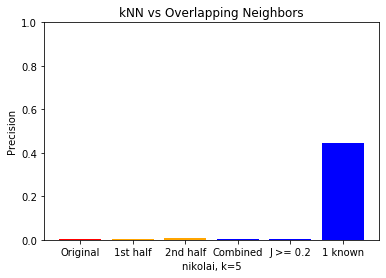

In [52]:
nikolai_precs_xs = ['Original', '1st half', '2nd half', 'Combined','J >= 0.2','1 known'] 
nikolai_precs_ys = [nikolai_all_precision,nikolai_first_half_precision,nikolai_second_half_precision,nikolai_all_prec,nikolai_J_prec,nikolai_known_prec]
nikolai_precs_colors = ['red','orange','orange','blue','blue','blue']
draw_bar(nikolai_precs_xs,nikolai_precs_ys,5,'nikolai','Precision','kNN vs Overlapping Neighbors',ylim=(0,1),colors=nikolai_precs_colors)

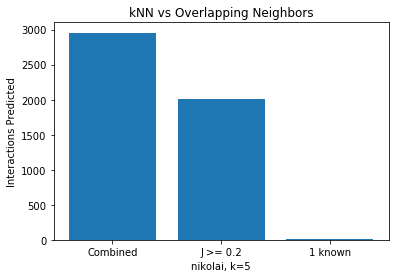

In [94]:
nikolai_count_xs = ['Combined','J >= 0.2','1 known'] 
nikolai_count_ys = [nikolai_all_count,nikolai_J_count,nikolai_known_count]
draw_bar(nikolai_count_xs,nikolai_count_ys,5,'nikolai','Interactions Predicted','kNN vs Overlapping Neighbors')

## pQTL + nikolai

In [58]:
from functools import reduce

shared_proteins = reduce(np.intersect1d, (nikolai_protein_ids, pQTL_protein_ids))

# proteomeHD_shared_df = proteomeHD_df.loc[proteomeHD_df['Simplified_protein_ID'].isin(shared_proteins)]
# proteomeHD_shared_df = proteomeHD_shared_df.drop_duplicates(subset='Simplified_protein_ID', keep='first')
# proteomeHD_shared_df = proteomeHD_shared_df.sort_values(by=['Simplified_protein_ID'])
# proteomeHD_shared_df_feature_matrix = proteomeHD_shared_df.iloc[:,4:].fillna(0).to_numpy()

pQTL_protein_shared_df = pQTL_protein_df.loc[pQTL_protein_df['uniprotswissprot'].isin(shared_proteins)]
pQTL_protein_shared_df = pQTL_protein_shared_df.sort_values(by=['uniprotswissprot'])
pQTL_protein_shared_df_feature_matrix = pQTL_protein_shared_df.iloc[:,2:].fillna(0).to_numpy()

nikolai_shared_df = nikolai_protein_df.loc[nikolai_protein_df['uniprot_id'].isin(shared_proteins)]
nikolai_shared_df = nikolai_shared_df.sort_values(by=['uniprot_id'])
nikolai_shared_df_feature_matrix = nikolai_shared_df.iloc[:,1:].fillna(0).to_numpy()

shared_lookup = {}
for idx,protein in enumerate(shared_proteins):
    shared_lookup[protein] = idx

In [60]:
# The next two lines takes about three minutes to run
k = 5
pQTL_closest_neighbors = list(map(lambda x: protein_query_simple(x,k,euclidean_dist,shared_proteins,pQTL_protein_shared_df_feature_matrix,shared_lookup),shared_proteins))
nikolai_closest_neighbors = list(map(lambda x: protein_query_simple(x,k,euclidean_dist,shared_proteins,nikolai_shared_df_feature_matrix,shared_lookup),shared_proteins))

NameError: name 'proteomeHD_closest_neighbors' is not defined

In [61]:
shared_neighbor_counts = calc_combined_counts(shared_proteins,pQTL_closest_neighbors,nikolai_closest_neighbors)

In [67]:
pQTL_nikolai_all_prec,pQTL_nikolai_J_prec,pQTL_nikolai_known_prec,pQTL_nikolai_all_count,pQTL_nikolai_J_count,pQTL_nikolai_known_count = combined_count_statistics(shared_neighbor_counts)

In [68]:
print(pQTL_nikolai_all_prec)
print(pQTL_nikolai_J_prec)
print(pQTL_nikolai_known_prec)
print(pQTL_nikolai_all_count)
print(pQTL_nikolai_J_count)
print(pQTL_nikolai_known_count)

0.2
0
0
15
0
0


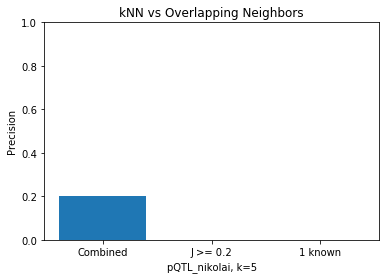

In [70]:
pQTL_nikolai_precs_xs = ['Combined','J >= 0.2','1 known'] 
pQTL_nikolai_precs_ys = [pQTL_nikolai_all_prec,pQTL_nikolai_J_prec,pQTL_nikolai_known_prec]
#pQTL_nikolai_precs_colors = ['red','orange','orange','blue','blue','blue']
draw_bar(pQTL_nikolai_precs_xs,pQTL_nikolai_precs_ys,5,'pQTL_nikolai','Precision','kNN vs Overlapping Neighbors',ylim=(0,1))

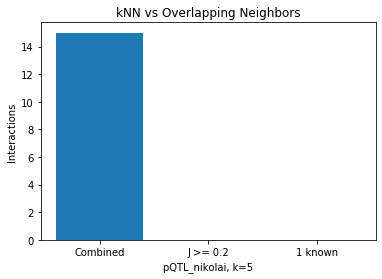

In [80]:
pQTL_nikolai_precs_xs = ['Combined','J >= 0.2','1 known'] 
pQTL_nikolai_precs_ys = [pQTL_nikolai_all_count,pQTL_nikolai_J_count,pQTL_nikolai_known_count]
pQTL_nikolai_precs_colors = ['blue','blue','blue']
draw_bar(pQTL_nikolai_precs_xs,pQTL_nikolai_precs_ys,5,'pQTL_nikolai','Interactions','kNN vs Overlapping Neighbors')

In [79]:
np.sum(np.array(shared_neighbor_counts)[:,1])

15.0

## proteomeHD + nikolai

In [81]:
from functools import reduce

shared_proteins = reduce(np.intersect1d, (nikolai_protein_ids, proteomeHD_simplified_protein_ids))

proteomeHD_shared_df = proteomeHD_df.loc[proteomeHD_df['Simplified_protein_ID'].isin(shared_proteins)]
proteomeHD_shared_df = proteomeHD_shared_df.drop_duplicates(subset='Simplified_protein_ID', keep='first')
proteomeHD_shared_df = proteomeHD_shared_df.sort_values(by=['Simplified_protein_ID'])
proteomeHD_shared_df_feature_matrix = proteomeHD_shared_df.iloc[:,4:].fillna(0).to_numpy()

nikolai_shared_df = nikolai_protein_df.loc[nikolai_protein_df['uniprot_id'].isin(shared_proteins)]
nikolai_shared_df = nikolai_shared_df.sort_values(by=['uniprot_id'])
nikolai_shared_df_feature_matrix = nikolai_shared_df.iloc[:,1:].fillna(0).to_numpy()

shared_lookup = {}
for idx,protein in enumerate(shared_proteins):
    shared_lookup[protein] = idx

In [82]:
# The next two lines takes about three minutes to run
k = 5
proteomeHD_closest_neighbors = list(map(lambda x: protein_query_simple(x,k,euclidean_dist,shared_proteins,proteomeHD_shared_df_feature_matrix,shared_lookup),shared_proteins))
nikolai_closest_neighbors = list(map(lambda x: protein_query_simple(x,k,euclidean_dist,shared_proteins,nikolai_shared_df_feature_matrix,shared_lookup),shared_proteins))

In [83]:
shared_neighbor_counts = calc_combined_counts(shared_proteins,proteomeHD_closest_neighbors,nikolai_closest_neighbors)

In [84]:
proteomeHD_nikolai_all_prec,proteomeHD_nikolai_J_prec,proteomeHD_nikolai_known_prec,proteomeHD_nikolai_all_count,proteomeHD_nikolai_J_count,proteomeHD_nikolai_known_count = combined_count_statistics(shared_neighbor_counts)

In [85]:
print(proteomeHD_nikolai_all_prec)
print(proteomeHD_nikolai_J_prec)
print(proteomeHD_nikolai_known_prec)
print(proteomeHD_nikolai_all_count)
print(proteomeHD_nikolai_J_count)
print(proteomeHD_nikolai_known_count)

0.08695652173913043
0
0
23
0
0


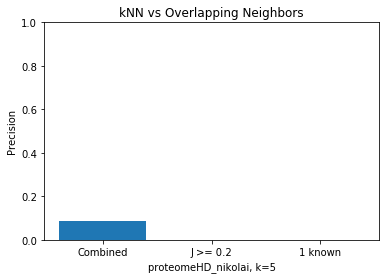

In [86]:
proteomeHD_nikolai_precs_xs = ['Combined','J >= 0.2','1 known'] 
proteomeHD_nikolai_precs_ys = [proteomeHD_nikolai_all_prec,proteomeHD_nikolai_J_prec,proteomeHD_nikolai_known_prec]
draw_bar(proteomeHD_nikolai_precs_xs,proteomeHD_nikolai_precs_ys,5,'proteomeHD_nikolai','Precision','kNN vs Overlapping Neighbors',ylim=(0,1))

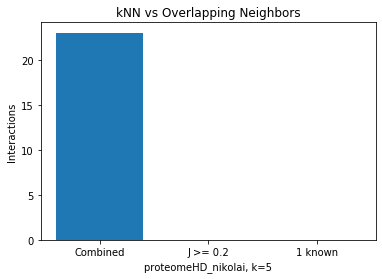

In [87]:
proteomeHD_nikolai_precs_xs = ['Combined','J >= 0.2','1 known'] 
proteomeHD_nikolai_precs_ys = [proteomeHD_nikolai_all_count,proteomeHD_nikolai_J_count,proteomeHD_nikolai_known_count]
proteomeHD_nikolai_precs_colors = ['blue','blue','blue']
draw_bar(proteomeHD_nikolai_precs_xs,proteomeHD_nikolai_precs_ys,5,'proteomeHD_nikolai','Interactions','kNN vs Overlapping Neighbors')

In [88]:
len(shared_proteins)

2016

In [89]:
np.sum(np.array(shared_neighbor_counts)[:,1])

23.0